<a href="https://colab.research.google.com/github/KimJunGu9/DeepLearning_Pytorch/blob/main/3_%EC%8B%9C%EA%B3%84%EC%97%B4_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# LSTM Cell


### 라이브러리 호출

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor # GPU 사용에 필요

torch.manual_seed(125)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(125)

### 데이터 전처리

In [4]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,)) # 평균을 0.5, 표준편차를 1.0으로 데이터 정규화
])

### 데이터셋 내려받기

In [5]:
from torchvision.datasets import MNIST

download_root = 'MNIST_DATASET/' # MNIST를 내려받을 경로

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
# transform : 앞에서 정의했던 데이터 전처리 적용
# train : True로 설정할 경우 훈련용 데이터셋을 가져오지만, False로 설정할 경우 테스트용 데이터셋 가져옴
# download : True로 설졍될경우 내려받으려는 위치가 MNIST파일이 없으면 내려받지만 파일이 있다면 내려받지않음

100%|██████████| 9912422/9912422 [00:00<00:00, 144495573.09it/s]

Extracting MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_DATASET/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30659502.36it/s]


Extracting MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_DATASET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38707625.21it/s]

Extracting MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_DATASET/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7216109.38it/s]


Extracting MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_DATASET/MNIST/raw



### 데이터셋을 메모리로 가져오기

In [6]:
batch_size = 64

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = batch_size,
                          shuffle = True)

valid_loader = DataLoader(dataset = valid_dataset,
                          batch_size = batch_size,
                          shuffle = True)

test_loader = DataLoader(dataset = test_dataset,
                          batch_size = batch_size,
                          shuffle = True)

### 변수 값 지정

In [7]:
batch_size = 100
n_iters = 6000

num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

### LSTM 셀 네트워크 구축

In [8]:
class LSTMCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias = True):
    super(LSTMCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 4 * hidden_size, bias = bias) # gates가 4개로 쪼개지는 상황이기때문에 4가 곱해짐
    self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias = bias)

  def reset_parameters(self): # 모델의 파라미터 초기화
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.datat.uniform_(-std, std) # uniform : 난수를 위해 사용

  def forward(self, x, hidden):
    hx, cx = hidden
    x = x.view(-1, x.size(1))

    gates = self.x2h(x) + self.h2h(hx)
    gates = gates.squeeze() # squeeze : 텐서의 차원을 줄일때 사용
    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
    # chunk(a,b) : a는 텐서를 몇개로 쪼갤지 설정, b는 어떤차원을 기준으로 쪼갤지 결정(dim=1이므로 열 단위로 텐서를 분할)

    ingate = F.sigmoid(ingate) # 입력게이트에 시그모이드 활성화 함수 적용
    forgetgate = F.sigmoid(forgetgate) # 망각게이트에 시그모이드 활성화 함수 적용
    cellgate = F.tanh(cellgate) # 셀 게이트에 탄젠트 활성화 함수 적용
    outgate = F.sigmoid(outgate) # 출력 게이트에 시그모이드 활성화 함수 적용

    cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate) # mul : 텐서에 곱셈을 할 때 사용
    hy = torch.mul(outgate, F.tanh(cy))
    # 하나의 LSTM셀을 통과하면 셀 상태와 은닉 상태가 출력으로 주어짐
    # 이때 셀 상태는 입력, 망각, 셀 게이트에 의해 계산되며, 은닉 상태는 출력 게이트에 의해 계산된다.
    return (hy, cy)

### LSTM 셀의 전반적인 네트워크

In [12]:
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
    super(LSTMModel, self).__init__()
    self.hidden_dim = hidden_dim # 은닉층의 뉴런/유닛 개수
    self.layer_dim = layer_dim
    self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)
    # input_dim : 입력에 대한 특성 수(칼럼 개수)
    # hidden_dim : 은닉층의 뉴런 개수
    # layer_dim : 은닉층의 계층 개수

  def forward(self, x):
    if torch.cuda.is_available(): # GPU 사용 유무 확인
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
      # (은닉층의 계층 개수, 배치 그기, 은닉층의 뉴런 개수)형태를 갖는 은닉 상태를 0으로 초기화
    else:
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    if torch.cuda.is_available(): # GPU 사용 유무 확인
      c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
    else:
      c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))
      # (은닉층의 계층 개수, 배치 그기, 은닉층의 뉴런 개수)형태를 갖는 은닉 상태를 0으로 초기화

    outs = []
    cn = c0[0,:,:]  # (은닉층의 계층 개수, 배치 그기, 은닉층의 뉴런 개수) 크기를 갖는 셀 상태에 대한 텐서
    hn = h0[0,:,:]  # (은닉층의 계층 개수, 배치 그기, 은닉층의 뉴런 개수) 크기를 갖는 은닉 상태에 대한 텐서

    for seq in range(x.size(1)): # LSTM 셀 계층을 반복하여 쌓아 올린다
      hn, cn = self.lstm(x[:,seq,:], (hn,cn)) # 은닉상태(hm)와 셀 상태를 LSTMCell에 적용한 결과를 또다시 hn,cn에 저장
      outs.append(hn)

    out = outs[-1].squeeze()
    out = self.fc(out)
    return out

### 옵티마이저와 손실 함수 지정

In [14]:
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available(): # GPU 사용 유무 확인
  model.cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

### 모델 학습 및 성능

In [16]:
seq_dim = 28
loss_list = []
iter = 0

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader): # 훈련 데이터셋을 이용한 모델 학습
    if torch.cuda.is_available(): # GPU 사용 유무 확
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
      labels = Variable(labels.cuda())
    else: # GPU를 사용하지 않기 때문에 else구문이 실행
      images = Variable(images.view(-1, seq_dim, input_dim))
      labels = Variable(labels)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels) # 손실 함수를 이용하여 오차 계산

    if torch.cuda.is_available():
      loss.cuda()

    loss.backward()
    optimizer.step() # 파라미터 업데이트
    loss_list.append(loss.item())
    iter += 1

    if iter % 500 == 0: # 정확도 계산
      correct = 0
      total = 0
      for images, labels in valid_loader: # 검증 데이터셋을 이용한 모델 성능 검증
        if torch.cuda.is_available():
          images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
          images = Variable(images.view(-1 , seq_dim, input_dim))

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # 모델을 통과한 결과의 최댓값으로부터 예측 결과 가져오기

        total += labels.size(0) # 총 레이블 수
        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum()
        else:
          correct += (predicted == labels).sum()

      accuracy = 100 * correct / total
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.1335464715957642. Accuracy: 60.34000015258789
Iteration: 1000. Loss: 0.30116981267929077. Accuracy: 86.91999816894531
Iteration: 1500. Loss: 0.21445170044898987. Accuracy: 92.9000015258789
Iteration: 2000. Loss: 0.09052927047014236. Accuracy: 94.43000030517578
Iteration: 2500. Loss: 0.05544540658593178. Accuracy: 96.33999633789062
Iteration: 3000. Loss: 0.0517357774078846. Accuracy: 96.43000030517578
Iteration: 3500. Loss: 0.03511272743344307. Accuracy: 96.87999725341797
Iteration: 4000. Loss: 0.09149031341075897. Accuracy: 96.80000305175781
Iteration: 4500. Loss: 0.11361894756555557. Accuracy: 97.18000030517578
Iteration: 5000. Loss: 0.03571777418255806. Accuracy: 97.45999908447266
Iteration: 5500. Loss: 0.10462290793657303. Accuracy: 97.18000030517578
Iteration: 6000. Loss: 0.14589880406856537. Accuracy: 97.73999786376953
Iteration: 6500. Loss: 0.12766876816749573. Accuracy: 97.80999755859375
Iteration: 7000. Loss: 0.0586576983332634. Accuracy: 97.889999389648

### 테스트 데이터셋을 이용한 모델 예측 성능 확인

In [17]:
def evaluate(model, val_iter):
  corrects, total, total_loss = 0, 0, 0
  model.eval()

  for images, labels in val_iter:
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
    else:
      images = Variable(images.view(-1 , seq_dim, input_dim)).to(device)

    labels = labels.cuda()
    logit = model(images).cuda()
    loss = F.cross_entropy(logit, labels, reduction = "sum") # reduction='sum'을 지정했기 때문에 모든 오차를 더함
    _, predicted = torch.max(logit.data, 1) # logit.data 텐서에서 최댓값의 인덱스를 반환
    total += labels.size(0)
    total_loss += loss.item()
    corrects += (predicted == labels).sum()

  avg_loss = total_loss / len(val_iter.dataset)
  avg_accuracy = corrects / total
  return avg_loss, avg_accuracy

### 모델 예측 성능 확인

In [18]:
test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.06 | Test Accuracy:  0.98


# LSTM

### 라이브러리 호출

In [20]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 데이터셋 가져오기

In [21]:
data=pd.read_csv('/content/drive/MyDrive/DL_pytorch/chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


### 날짜 칼럼을 인덱스로 사용

In [23]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

### 데이터 형식 변경

In [24]:
data['Volume'] = data['Volume'].astype(float)

### 훈련과 레이블 분리

In [25]:
X=data.iloc[:,:-1] # 마지막 칼럼을 제외한 모든 칼럼을 x로 사용
y=data.iloc[:,5:6] # 마지막 'Volume'을 레이블로 사용

print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

### 데이터 분포 조정

In [26]:
ms = MinMaxScaler() # 데이터의 모든 값이 0~1 사이에 존재하도록 분산 조정
ss = StandardScaler() # 데이터가 평균 0, 분산 1이 되도록 분산 조정

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :] # 훈련 데이터셋
X_test = X_ss[200:, :] # 테스트 데이터셋

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


### 데이터셋의 형태 및 크기 조정

In [27]:
X_train_tensors = Variable(torch.Tensor(X_train)) # Variable로 감싸진 텐서는 .backward()가 호출될때 자동으로 기울기가 계산
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
# reshape는 텐서의 형태를 바꿀 때 사용. 훈련 데이터셋(X_train_tensors)의 형태(200,5)를 (200,1,5)로 변경
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))


print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


### LSTM네트워크

In [28]:
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM, self).__init__()
    self.num_classes = num_classes # 클래스 개수
    self.num_layers = num_layers # LSTM 계층 개수
    self.input_size = input_size # 입력 크기로 훈련 데이터셋의 칼럼 개수 의미
    self.hidden_size = hidden_size # 은닉층의 뉴런 개수
    self.seq_length = seq_length # 시퀀스 길이
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) # LSTM 계층
    self.fc_1 =  nn.Linear(hidden_size, 128) # 완전연결층
    self.fc = nn.Linear(128, num_classes) # 출력층
    self.relu = nn.ReLU()

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉 상태를 0으로 초기화
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 셀 상태를 0으로 초기화
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
    hn = hn.view(-1, self.hidden_size) # 완전연결층 적용을 위해 데이터의 형태 조정(1차원으로 조정)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

### 변수 값 설정

In [29]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5 # 입력 데이터셋의 칼럼(feature) 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1 # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])
# 앞에서 정의한 값들을 이용하여 LSTM 모델 학습

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 모델 학습

In [30]:
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f) # 전방향(forward) 학습
  optimizer.zero_grad()
  loss = criterion(outputs, y_train_tensors)
  # 손실함수를 이용한 오차 계산(모델 학습 결과(output)와 레이블(y_train_tensors)의 차이 계산)
  loss.backward() # 기울기 계산
  optimizer.step() # 오차 업데이트

  if epoch % 100 == 0: # 1000을 100으로 나누어 나머지가 0이면 출력
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.06710
Epoch: 100, loss: 0.03971
Epoch: 200, loss: 0.03896
Epoch: 300, loss: 0.03795
Epoch: 400, loss: 0.03665
Epoch: 500, loss: 0.03541
Epoch: 600, loss: 0.03445
Epoch: 700, loss: 0.03378
Epoch: 800, loss: 0.03332
Epoch: 900, loss: 0.03299


### 모델 예측 결과를 출력하기 위한 데이터 크기 재구성

In [31]:
df_x_ss = ss.transform(data.iloc[:, :-1]) # 데이터 정규화(분포 조정)
df_y_ms = ms.transform(data.iloc[:, -1:]) # 데이터 정규화

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

### 모델 예측 결과 출력

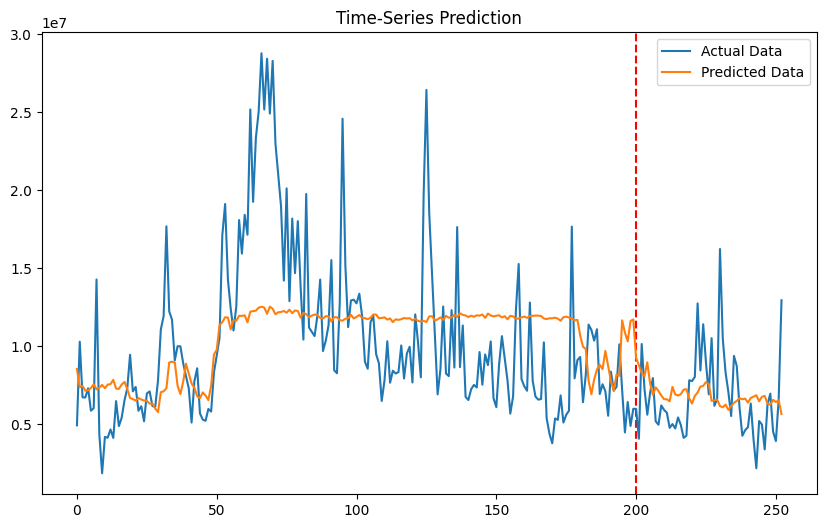

In [32]:
train_predict = model(df_x_ss) # 훈련 데이터셋을 모델에 적용하여 모델 학습
predicted = train_predict.data.numpy() # 모델 학습 결과를 넘파이로 변경
label_y = df_y_ms.data.numpy()

predicted= ms.inverse_transform(predicted)
# 모델학습을 위해 전처리(정규화)했던 것을 해제(그래프의 본래 값을 출력하기위한 목적)
label_y = ms.inverse_transform(label_y)

plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

# GRU Cell

### 라이브러리 호출

In [33]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

### 데이터 전처리

In [34]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

### 데이터셋 내려받기 및 전처리 적용

In [35]:
from torchvision.datasets import MNIST
download_root = 'MNIST_DATASET/'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

### 데이터셋 메모리로 가져오기

In [36]:
batch_size = 64

train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

### 변수 값 설정

In [37]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

### GRU 셀 네트워크

In [46]:
class GRUCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super(GRUCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
    # LSTM셀에서는 4를 곱했지만 GRU셀에서는 3개의 게이트가 사용되므로 3을 곱함
    # 엄밀히 게이트는 두 개(망각, 입력 게이트)이지만 탄젠트 활성화 함수가 적용되는
    # 부분을 '새로운 게이트(newgate)'로 정의하여 총 3을 곱함
    self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
    self.reset_parameters()

  def reset_parameters(self): # 파라미터 초기화
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, x, hidden):
    x = x.view(-1, x.size(1))
    gate_x = self.x2h(x) # LSTM셀에서는 gates를 x2h + h2h로 정의했지만 GRU셀에서는 개별적인 상태를 유지
    gate_h = self.h2h(hidden)
    gate_x = gate_x.squeeze()
    gate_h = gate_h.squeeze()

    i_r, i_i, i_n = gate_x.chunk(3, 1) # 총 세 개의 게이트(망각, 입력, 새로운 게이트)를 위해 세 개로 쪼개짐
    h_r, h_i, h_n = gate_h.chunk(3, 1)

    resetgate = F.sigmoid(i_r + h_r)
    inputgate = F.sigmoid(i_i + h_i)
    newgate = F.tanh(i_n + (resetgate * h_n)) # '새로운 게이트'는 탄젠트 활성화 함수가 적용된 게이트

    hy = newgate + inputgate * (hidden - newgate)
    return hy

### 전반적인 네트워크 구조

In [47]:
class GRUModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
    super(GRUModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim
    self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim) # 앞에서 정의한 GRU Cell 함수로 불러옴
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    if torch.cuda.is_available():
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
    else:
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    outs = []
    hn = h0[0,:,:] # LSTM셀에서는 셀 상태에 대해서도 정의했었지만 GRU 셀에서는 셀은 사용되지않음

    for seq in range(x.size(1)):
      hn = self.gru_cell(x[:,seq,:], hn)
      outs.append(hn)

    out = outs[-1].squeeze()
    out = self.fc(out)
    return out

### 옵티마이저와 손실 함수 설정

In [48]:
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available():
  model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 모델 학습 및 성능 검증

In [51]:
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1 , seq_dim, input_dim))

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6724593043327332. Accuracy: 85.0
Iteration: 1000. Loss: 0.35811829566955566. Accuracy: 90.05999755859375
Iteration: 1500. Loss: 0.3955090343952179. Accuracy: 92.48999786376953
Iteration: 2000. Loss: 0.10709834843873978. Accuracy: 95.04000091552734
Iteration: 2500. Loss: 0.11268039047718048. Accuracy: 95.77999877929688
Iteration: 3000. Loss: 0.32674214243888855. Accuracy: 96.16000366210938
Iteration: 3500. Loss: 0.03186342865228653. Accuracy: 96.97000122070312
Iteration: 4000. Loss: 0.13673268258571625. Accuracy: 96.91000366210938
Iteration: 4500. Loss: 0.02443329431116581. Accuracy: 97.23999786376953
Iteration: 5000. Loss: 0.06422528624534607. Accuracy: 97.69999694824219
Iteration: 5500. Loss: 0.08957058936357498. Accuracy: 97.88999938964844
Iteration: 6000. Loss: 0.06529176980257034. Accuracy: 97.81999969482422
Iteration: 6500. Loss: 0.08784162998199463. Accuracy: 97.69000244140625
Iteration: 7000. Loss: 0.07583820819854736. Accuracy: 97.9800033569336
Iteration

### 테스트 데이터셋을 이용한 모델 예측

In [52]:
def evaluate(model, val_iter):
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter:
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
            images = Variable(images.view(-1 , seq_dim, input_dim)).to(device)
        labels = labels.cuda()
        logit = model(images).cuda()
        loss = F.cross_entropy(logit, labels, reduction = "sum")
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

### 모델 예측 결과

In [53]:
test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.05 | Test Accuracy:  0.98


# GRU

### 라이브러리 호출

In [54]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 데이터셋 불러오기

In [55]:
data=pd.read_csv('/content/drive/MyDrive/DL_pytorch/chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


### 인덱스 설정 및 데이터 타입 변경

In [56]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

### 훈련과 레이블 데이터셋 분리

In [57]:
X=data.iloc[:,:-1]
y=data.iloc[:,5:6]

print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

### 훈련과 테스트 데이터셋 정규화

In [58]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


### 데이터셋 형태 변경

In [59]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


### GRU 모델의 네트워크

In [60]:
class GRU(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(GRU, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True)
    self.fc_1 =  nn.Linear(hidden_size, 128)
    self.fc = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
    # 은닉 상태에 대해 0으로 초기화하는 부분으로, LSTM계층은 셀 상태가 있었지만 GRU는 셀 상태를 정의하지 않음
    output, (hn) = self.gru(x, (h_0))
    hn = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

### 옵티마이저와 손실 함수 지정

In [63]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1 # GRU 계층의 개수

num_classes = 1
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 모델 학습

In [64]:
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()
  loss = criterion(outputs, y_train_tensors)
  loss.backward()

  optimizer.step()
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.08132
Epoch: 100, loss: 0.03357
Epoch: 200, loss: 0.03165
Epoch: 300, loss: 0.03049
Epoch: 400, loss: 0.02930
Epoch: 500, loss: 0.02807
Epoch: 600, loss: 0.02689
Epoch: 700, loss: 0.02560
Epoch: 800, loss: 0.02415
Epoch: 900, loss: 0.02274


### 그래프 출력을 위한 전처리

In [65]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

### 모델 예측 결과 출력

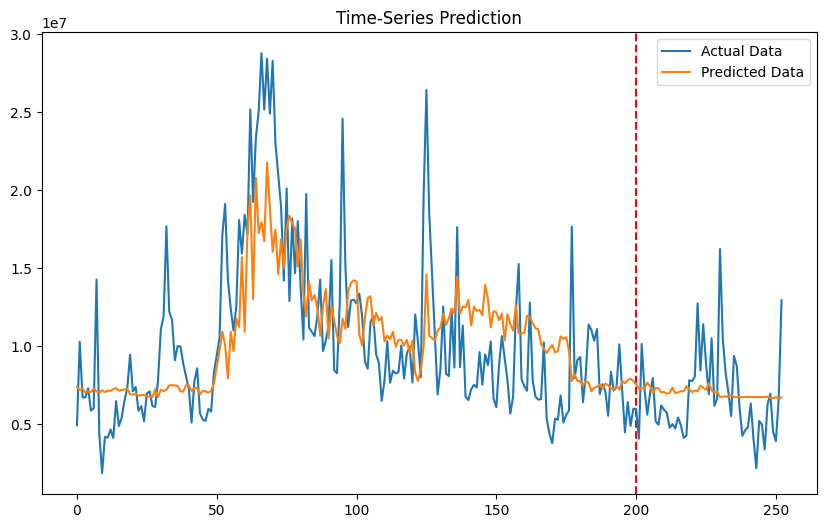

In [66]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

# 양방향 LSTM

### 모델을 생성하고 학습

In [67]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


data=pd.read_csv('/content/drive/MyDrive/DL_pytorch/chap07/data/SBUX.csv')
print(data.dtypes)


data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)


X=data.iloc[:,:-1]
y=data.iloc[:,5:6]


ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]


X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


### 모델의 네트워크

In [68]:
class biLSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(biLSTM, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, bidirectional=True, batch_first=True)
    self.fc =  nn.Linear(hidden_size*2, num_classes)
    self.relu = nn.ReLU()
    # bidirectional=True : 양방향 LSTM을 사용하겠다는 의미
    # 양방향 RNN, 양방향 GRU 모두 해당됨

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
    c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
    out, _ = self.lstm(x, (h_0, c_0))
    out = self.fc(out[:, -1, :]) # 마지막시간(time step상 마지막 단계)의 은닉 상태
    out = self.relu(out)
    return out

### 모델 학습

In [69]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = biLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [70]:
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()

  loss = criterion(outputs, y_train_tensors)
  loss.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.13592
Epoch: 100, loss: 0.12963
Epoch: 200, loss: 0.12145
Epoch: 300, loss: 0.11395
Epoch: 400, loss: 0.10432
Epoch: 500, loss: 0.09031
Epoch: 600, loss: 0.07544
Epoch: 700, loss: 0.06317
Epoch: 800, loss: 0.05518
Epoch: 900, loss: 0.05020


### 모델 평가

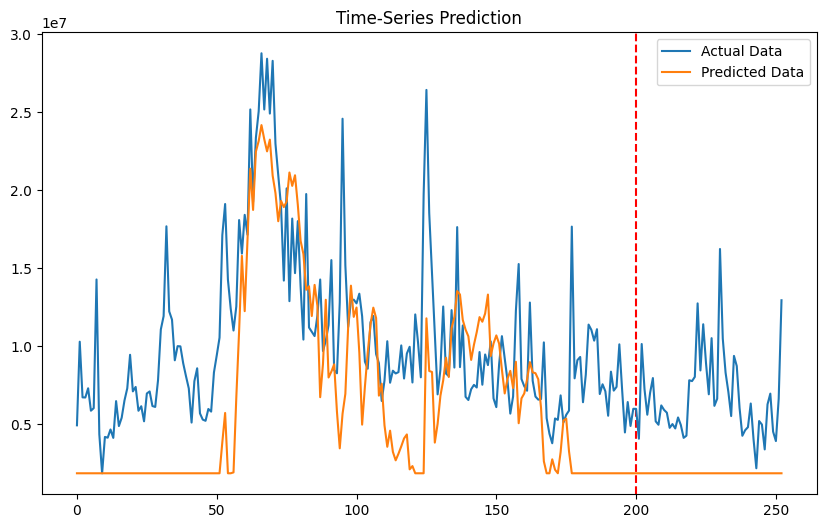

In [71]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))


train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()